In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from multi_arm import epsilon_greedy

seed = 11
np.random.seed(seed)

### Simulation Setup

__two-sample z test__ is performed between the winner and second place arms. Algorithm is terminated if the two arms show statistical significance.

```python
def two_sample_z_test(est_p, wins, traffic, alpha=0.05):
    """
    Perform two-sample z test on champion arm and second arm.
    
    Parameters
    ----------
    est_p list[float]: estimated click through rates
    wins list[int]: conversion for each arm
    traffic list[int]: traffic diverted to each arm
    alpha float: false positive rate (tyoe I error)
    
    Returns true if statistically significant.
    """
    winner_idx = np.argmax(est_p)
    second_idx = sorted([(p, i) for i, p in enumerate(est_p)])[-2][1]
    
    p0, p1 = est_p[winner_idx], est_p[second_idx]
    x0, x1 = wins[winner_idx], wins[second_idx]
    n0, n1 = traffic[winner_idx], traffic[second_idx]

    p_pooled = (x0 + x1) / (n0 + n1)
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1 / n0 + 1 / n1))
    
    # note that z is guaranteed to be positive
    z = (p0 - p1) / se
    p_val = 2 * (1 - norm.cdf(abs(z)))
    
    return p_val < alpha
```

__epsilon-greedy algorithm__ divert traffic to winning arm with probability $1-\epsilon$, randomly explore non-winning arm with probability $\epsilon$.

```python
def epsilon_greedy(ctrs, alpha=0.05, epsilon=0.3, burn_in=100, max_iter=100000, silent=False):
    """
    With probability epsilon, randomly explore a non-optimal arm.
    Otherwise, greedily exploit current winning arm. 

    Experiment is terminated when champion arm defeats the second 
    place with statistical significance.

    Parameters
    ----------
    ctrs list[float]: true click through rates for each arms.
    alpha float: false positive rate (tyoe I error)
    burn_in int: minimum number of iterations.
    max_iter int: maxinum number of iterations.
    silent bool: print status at the end of experiment.

    Returns
    -------
    winner_idx int: winner's index.
    est_ctrs list[float]: estimated click through rates.
    wins list[int]: number of conversion in each arm.
    traffic list[int]: number of traffic in each arm.
    history_ctr list[list[float]]: storing est_ctrs.
    """
    idx = winner_idx = 0
    n_arms = len(ctrs)
    history_ctr = [[] for _ in range(n_arms)]

    traffic = np.array([1] * n_arms)
    wins = np.array([int(np.random.rand() < ctr) for ctr in ctrs])

    for i in range(max_iter):    
        if np.random.rand() < epsilon:
            # randomly choose a arm
            idx = np.random.randint(0, len(ctrs))
        else:
            # greedily use the best arm
            idx = winner_idx
        ctr = ctrs[idx]

        # new user arrives
        wins[idx] += int(np.random.rand() < ctr)
        traffic[idx] += 1

        # record estimated click through rates
        est_ctrs = wins / traffic
        for j, p in enumerate(est_ctrs):
            history_ctr[j].append(p)

        # update champion's index
        winner_idx = np.argmax(est_ctrs)

        # terminate if statistical significant
        if i >= burn_in:
            if two_sample_z_test(est_ctrs, wins, traffic, alpha):
                if not silent: print("Winning arm %i beats second arm at iteration %i"%(winner_idx, i + 1))
                break
    return winner_idx, est_ctrs, wins, traffic, history_ctr
```

### A Single Trial

In [2]:
ctrs = [0.04, 0.048, 0.03, 0.037, 0.044]

true_winner_idx = np.argmax(ctrs)
print("true_winner_idx:", true_winner_idx)

epsilon = 0.2
alpha = 0.05
winner_idx, est_p, wins, traffic, history_ctr = epsilon_greedy(ctrs, alpha, epsilon, burn_in=5000)

true_winner_idx: 1
Winning arm 1 beats second arm at iteration 6069


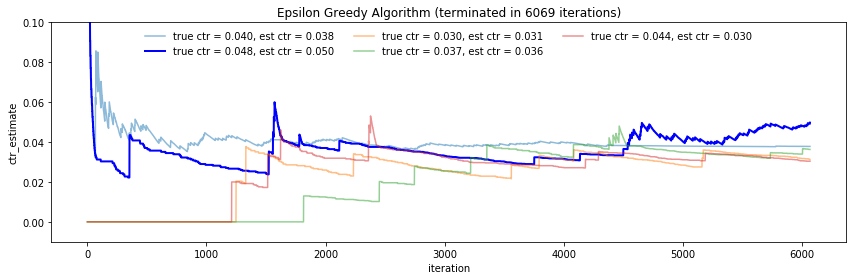

In [3]:
# iteration is same as sum(traffic) - len(ctrs)
history = history_ctr

# History Plot
plt.figure(figsize=(12, 4))
for i, hist in enumerate(history):
    if i == true_winner_idx :
        plt.plot(hist, lw=2, color='b')
    elif i == winner_idx:
        plt.plot(hist, lw=2, color='r')
    else:
        plt.plot(hist, alpha=0.5)

legend = ["true ctr = %.3f, est ctr = %.3f"%(true, est) for true, est in zip(ctrs, est_p)]
plt.legend(legend, frameon=False, loc='upper center', ncol=3)

plt.title("Epsilon Greedy Algorithm (terminated in %i iterations)"%(sum(traffic) - len(ctrs)))
plt.xlabel("iteration")
plt.ylabel("ctr_estimate")
plt.ylim(-0.01, 0.1)
plt.tight_layout()
plt.show()

In [4]:
conversion = 100 * sum(wins) / sum(traffic)
baseline = 100 * sum(np.array(ctrs) * (sum(traffic) / len(ctrs))) / sum(traffic)
print("good traffic: %i / %i = %.2f%%, baseline %.2f%%"%(sum(wins), 
                                                         sum(traffic), 
                                                         conversion,
                                                         baseline))

good traffic: 244 / 6074 = 4.02%, baseline 3.98%


##### Moving Average Smoothing

In [5]:
cols = ["arm_%i_ctr=%.2f"%(i + 1, ctr) for i, ctr in enumerate(ctrs)]
data = {col : hist for col, hist in zip(cols, history)}
df_history = pd.DataFrame(data)

df_history_ma = df_history.rolling(200).mean()

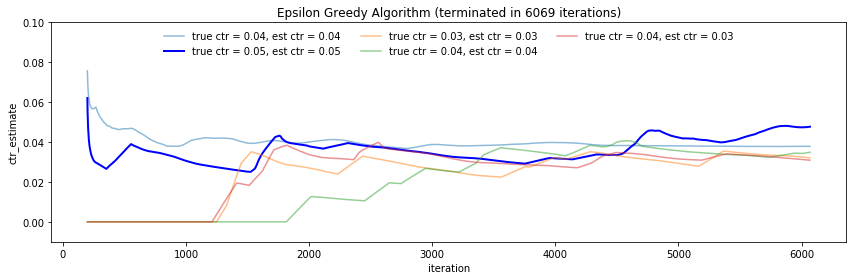

In [6]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(cols):
    if i == true_winner_idx :
        plt.plot(df_history_ma[col], lw=2, color='b')
    elif i == winner_idx:
        plt.plot(df_history_ma[col], lw=2, color='r')
    else:
        plt.plot(df_history_ma[col], alpha=0.5)
    
legend = ["true ctr = %.2f, est ctr = %.2f"%(true, est) for true, est in zip(ctrs, est_p)]
plt.legend(legend, frameon=False, loc='upper center', ncol=3)

plt.title("Epsilon Greedy Algorithm (terminated in %i iterations)"%(sum(traffic) - len(ctrs)))
plt.xlabel("iteration")
plt.ylabel("ctr_estimate")
plt.ylim(-0.01, 0.1)
plt.tight_layout()
# plt.savefig('outputs/epsilon_%.2f_greedy.png'%epsilon, transparent=True)
plt.show()

### True Positive Rate

In [7]:
start = time()

ctrs = [0.04, 0.05]
alpha = 0.05
epsilon = 0.5
true_winner_idx = np.argmax(ctrs)
n_trials = 100
success = 0
iters = []

for i in range(n_trials):
    winner_idx, _, _, traffic, _ = epsilon_greedy(ctrs=ctrs, alpha=alpha, epsilon=epsilon, silent=True)
    iters.append(sum(traffic) - len(ctrs))
    if winner_idx == true_winner_idx:
        success += 1
        
    success_rate = 100 * success / (i + 1)
    print("Progress %.2f%%, success rate %.2f%%..."%(100 * (i + 1) / n_trials, success_rate), end="\r")
print("probability of finding winner: %.2f%%"%(100 * success / n_trials))

end = time()
print("time elapsed: %.2fs"%(end - start))

probability of finding winner: 95.00%...
time elapsed: 59.77s


average iteration 4907.81, median 2990.00, std 5096.80


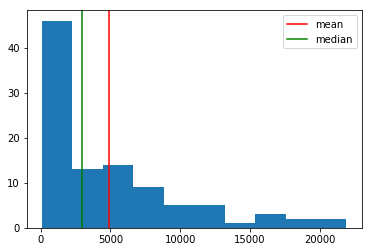

In [8]:
print("average iteration %.2f, median %.2f, std %.2f"%(np.mean(iters), np.median(iters), np.std(iters)))

plt.axvline(np.mean(iters), color='r')
plt.axvline(np.median(iters), color='g')
plt.hist(iters)

plt.legend(["mean", "median"])
plt.show()

### Epsilon Search

In [9]:
np.linspace(0.1, 0.8, 8)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [11]:
cols = ["n_arms", "epsilon", "true_winner_idx", "winner_idx", "true_winner_ctr", "winner_ctr", "traffic", "wins", "baseline"]

df_ep = pd.DataFrame(columns=cols)

ns_arms = [2, 3, 4, 5, 10, 15, 20]
n_trials = 16
epsilons = np.linspace(0.1, 0.8, 8)
for n_arms in ns_arms:
    for i, ep in enumerate(epsilons):
        for j in range(n_trials):
            ctrs = np.random.normal(0.2, 0.05, n_arms)
            true_winner_idx = np.argmax(ctrs)

            winner_idx, est_p, wins, traffic, history = epsilon_greedy(ctrs=ctrs, 
                                                                       epsilon=ep, 
                                                                       burn_in=1000, 
                                                                       silent=True)
            vals = [n_arms, ep, true_winner_idx, winner_idx, ctrs[true_winner_idx], ctrs[winner_idx], sum(traffic), sum(wins), np.mean(ctrs)]
            df_ep = df_ep.append({key : val for key, val in zip(cols, vals)}, ignore_index=True)
        
            print("%i arm, epsilon %.2f, trial %i"%(n_arms, ep, j) , end='\r')

In [ ]:
# df_ep.to_csv('outputs/df_ep_epsilon_search.csv')

##### Analyze results

In [12]:
df_ep = pd.read_csv('outputs/df_ep_epsilon_search.csv')

In [13]:
df_ep["conversion"] = df_ep.wins / df_ep.traffic

In [14]:
import pandasql

q = """
SELECT 
    epsilon
    ,AVG(wins) AS wins
    ,AVG(traffic) AS traffic
    ,AVG(conversion) AS conversion
    ,AVG(baseline) AS baseline
    ,SUM(CASE WHEN true_winner_idx = winner_idx THEN 1 ELSE 0 END) AS success
FROM %s
GROUP BY epsilon
"""

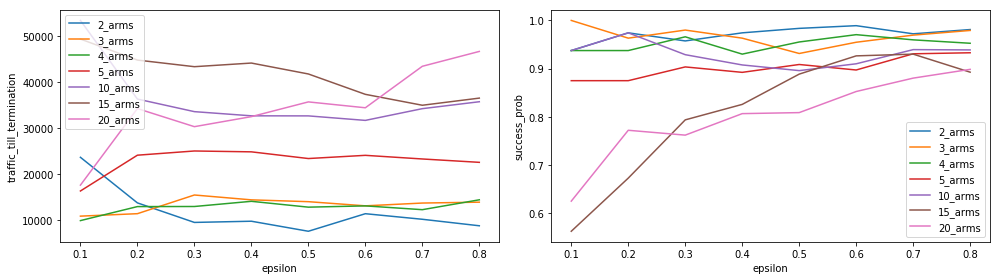

In [15]:
plt.figure(figsize=(14, 4))

ax1 = plt.subplot(1, 2, 1)
for n_arms in ns_arms:
    df_ep_subset = df_ep[df_ep.n_arms == n_arms]

    df_ep_agg = pandasql.sqldf(q.lower()%"df_ep_subset", locals())
    
    ax1.plot(df_ep_agg.epsilon, df_ep_agg.traffic.ewm(alpha=0.3).mean())
ax1.legend(['%i_arms'%i for i in ns_arms])

ax1.set_xlabel("epsilon")
ax1.set_ylabel("traffic_till_termination")

ax2 = plt.subplot(1, 2, 2)
for n_arms in ns_arms:
    df_ep_subset = df_ep[df_ep.n_arms == n_arms]

    df_ep_agg = pandasql.sqldf(q.lower()%"df_ep_subset", locals())
    df_ep_agg["success_prob"] = df_ep_agg["success"] / n_trials
    
    ax2.plot(df_ep_agg.epsilon, df_ep_agg.success_prob.ewm(alpha=0.3).mean())
ax2.legend(['%i_arms'%i for i in ns_arms])

ax2.set_xlabel("epsilon")
ax2.set_ylabel("success_prob")

plt.tight_layout()

# plt.savefig('outputs/compare_epsilon_search_%i-%i_arms_combined.png'%(ns_arms[0], ns_arms[-1]))